In [1]:
pip install pykalman


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 3.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [151]:
df=pd.read_csv('drive/MyDrive/lab4/Eximbank.csv')
df
df1=df.reset_index()['Close']

In [152]:
df

,Date,Open,High,Low,Close,Volume
0,2019-03-01 00:00:00+07:00,12323.44629,12429.37891,12005.64941,12217.51367,101102
1,2019-03-04 00:00:00+07:00,12217.51367,12711.86426,12146.89258,12570.62109,1698208
2,2019-03-05 00:00:00+07:00,12570.62109,12570.62109,12252.82520,12252.82520,1940443
3,2019-03-06 00:00:00+07:00,12535.31055,12535.31055,12252.82520,12288.13574,40228
4,2019-03-07 00:00:00+07:00,12076.27148,12288.13574,12005.64941,12076.27148,4753044
...,...,...,...,...,...,...
1301,2024-05-27 00:00:00+07:00,18000.00000,18850.00000,17900.00000,18800.00000,23321600
1302,2024-05-28 00:00:00+07:00,18900.00000,18950.00000,18550.00000,18750.00000,14183500
1303,2024-05-29 00:00:00+07:00,18750.00000,19700.00000,18600.00000,19650.00000,34878400
1304,2024-05-30 00:00:00+07:00,19400.00000,19750.00000,19300.00000,19700.00000,17593880


In [153]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [154]:
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [155]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [156]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest= create_dataset(test_data, time_step)

In [157]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)



(943, 100)
(943,)
(161, 100)
(161,)


In [158]:
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=X_train[0][0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [159]:
kf = kf.em(X_train[0])

In [160]:
test_data.shape

(262, 1)

In [161]:
test_observed = test_data
test_predicted, _ = kf.filter(test_observed)


In [162]:
test_predicted.shape

(262, 1)

In [163]:
test_predicted=scaler.inverse_transform(test_predicted)
ytest=ytest.reshape(-1,1)
ytest=scaler.inverse_transform(test_data)

In [164]:
test_rmse = np.sqrt(np.mean((test_predicted - ytest)**2))
test_mae = mean_absolute_error(test_predicted, ytest)
test_mape = np.mean(np.abs(test_predicted - ytest)/np.abs(test_predicted))*100

In [165]:
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 230.39901081991846
Testing MAPE: 0.6654385642037041
Testing MAE: 117.18795494377491


In [166]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape[1]

202

In [167]:
test_data[60:].shape

(202, 1)

In [168]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        #print(x_input)
        yhat, _ = kf.filter(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat[-1].tolist())
        i=i+1
    else:
        x_input = x_input.reshape(n_steps)
        yhat, _ = kf.filter(x_input)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat[-1].tolist())
        i=i+1

Streaming output truncated to the last 5000 lines.
 [0.23634063]
 [0.23618259]
 [0.23573313]
 [0.23164232]
 [0.23332651]
 [0.23392765]
 [0.23414221]
 [0.22124848]
 [0.21075078]
 [0.21093427]
 [0.20706936]
 [0.20669606]
 [0.19404058]
 [0.1825667 ]
 [0.1845006 ]
 [0.17869785]
 [0.18126456]
 [0.17986176]
 [0.17054911]
 [0.16908033]
 [0.16577336]
 [0.16830331]
 [0.17152525]
 [0.17545797]
 [0.17732544]
 [0.17613685]
 [0.17571261]
 [0.17370604]
 [0.17252605]
 [0.16978595]
 [0.1701993 ]
 [0.17591227]
 [0.17841517]
 [0.18441017]
 [0.1846948 ]
 [0.17644823]
 [0.17907025]
 [0.17536826]
 [0.16987283]
 [0.1706941 ]
 [0.17516131]
 [0.17861092]
 [0.18169732]
 [0.18001622]]
69 day input [0.40403656 0.38332724 0.3859159  0.44804387 0.45839853 0.4532212
 0.42733455 0.41697989 0.4532212  0.41697989 0.43251188 0.41180255
 0.40403656 0.40144789 0.40662522 0.41180255 0.43251188 0.42474588
 0.44286654 0.45063253 0.4532212  0.44804387 0.44804387 0.44804387
 0.40921389 0.39109323 0.41180255 0.41956855 0.41180

In [169]:
# Chuyển danh sách thành mảng numpy
values_array = np.array(lst_output)

# Nếu bạn thực sự cần reshape (ví dụ: thành mảng 2D 1 hàng)
values_reshaped = values_array.reshape(-1, 1)

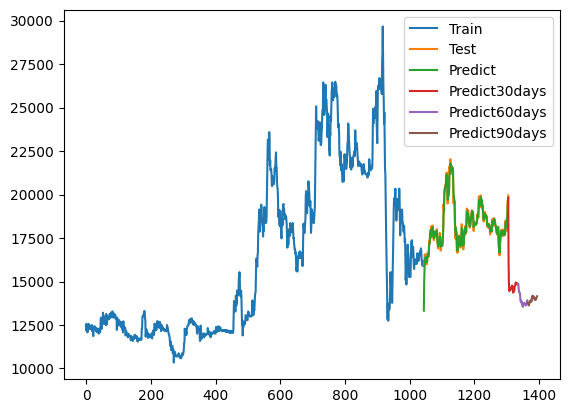

In [170]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_predicted)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.show()



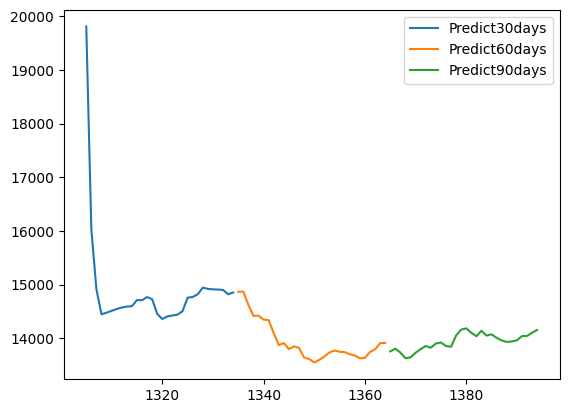

In [171]:


prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[60:90]))

plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.show()